In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
img_size = 784
img_shape = (28, 28)

train_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_test.csv'), delimiter=',')

### Create dataset

In [3]:
def onehot(n: int, i: int) -> np.ndarray:
    v = np.zeros(n)
    v[i] = 1.0
    return v

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([onehot(10, int(i)) for i in train_data[:,0]])
label_train = train_data[:,0].astype(np.int32)

x_test = test_data[:,1:] / 255.0
y_test = np.array([onehot(10, int(i)) for i in test_data[:,0]])
label_test = test_data[:,0].astype(np.int32)

### Define functions and model

In [5]:
def softmax(x: np.ndarray, axis=0, keepdims=True) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y, axis=axis, keepdims=keepdims)

def cross_entropy(p: np.ndarray, q: np.ndarray) -> float:
    return -np.sum(p * np.log(q))

In [6]:
class Perceptron:
    def __init__(self, n_in: int, n_out: int) -> None:
        self.W: np.ndarray = np.random.uniform(-0.01, 0.01, (n_in, n_out))
        self.b: np.ndarray = np.zeros(n_out)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        if x.ndim == 1:
            x = x.reshape((1, x.size))
        p = softmax(x @ self.W + self.b, axis=1)
        return p.ravel() if len(p) == 1 else p

    def save(self, fp: Path) -> None:
        np.savez(fp, w=self.W, b=self.b)

    def load(self, fp: Path) -> None:
        params = np.load(fp)
        self.W, self.b = params['w'], params['b']

def loss(model: Perceptron, X: np.ndarray, P: np.ndarray) -> float:
    return np.mean([cross_entropy(p,q) for (p,q) in zip(P,model(X))])

def accuracy(model: Perceptron, X: np.ndarray, P: np.ndarray) -> float:
    fn = lambda a, b: 1 if np.argmax(a) == np.argmax(b) else 0
    return np.mean([fn(p,q) for (p,q) in zip(P,model(X))])

### SGD Implementation

In [7]:
def train(model: Perceptron, X: np.ndarray, Y: np.ndarray, lr, batch_size, max_epoch) -> None:
    n_samples = len(x_test)
    n_batches = n_samples // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n_samples)
        batches = np.array_split(idxs, n_batches)

        for batch in batches:
            dLdy = model(X[batch]) - Y[batch]
            dW = np.mean(np.einsum('ij,ik->ijk', X[batch], dLdy), axis=0)
            db = np.mean(dLdy, axis=0)
            
            model.W -= lr * dW
            model.b -= lr * db

### Create, train and test model

In [9]:
n_in = 784
n_out = 10

learning_rate = 0.1
batch_size = 64
max_epoch = 8

model = Perceptron(n_in, n_out)

print(f"untrained loss: {round(loss(model, x_test, y_test), 3)}")
train(model, x_train, y_train, learning_rate, batch_size, max_epoch)
print(f"trained loss: {round(loss(model, x_test, y_test), 3)}")

model_accuracy = accuracy(model, x_test, y_test)
print(f"test set accuracy: {round(model_accuracy * 100, 2)}%")

untrained loss: 2.305
trained loss: 0.334
test set accuracy: 90.8%


### Save, load and test model

In [10]:
fp = Path('D:/Development/Data/tmp/parameters.npz')
model.save(fp)

In [11]:
model = Perceptron(n_in, n_out)
model.load(fp)

In [12]:
model_loss = loss(model, x_test, y_test)
model_accuracy = accuracy(model, x_test, y_test)

print(f"loss: {round(model_loss, 3)}")
print(f"accuracy: {round(model_accuracy * 100, 2)}%")

loss: 0.334
accuracy: 90.8%


### Caclculating Precision, Recall and Accuracy for a single digit

In [13]:
TP, TN, FP, FN = 0, 0, 0, 0
digit = 1

for x, true_label in zip(x_test, label_test):
    label_guess = np.argmax(model(x))

    if true_label == digit:
        if label_guess == digit:
            TP += 1
        else:
            FN += 1
    else:
        if label_guess == digit:
            FP += 1
        else:
            TN += 1

print(f"digit '{digit}'")

print(f"TP: {TP}; FN: {FN}")
print(f"FP: {FP}; TN: {TN}")

precision = round(TP / (TP + FP), 3)
recall = round(TP / (TP + FN), 3)
accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)

print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"accuracy: {accuracy}")

digit '1'
TP: 1102; FN: 33
FP: 53; TN: 8812
precision: 0.954
recall: 0.971
accuracy: 0.991


### Caclculating Precision, Recall and Accuracy for all digits

In [14]:
counts = {'TP': np.zeros(10),'TN': np.zeros(10),'FP': np.zeros(10),'FN': np.zeros(10)}
label_guess_test = np.apply_along_axis(np.argmax, 1, model(x_test))

for label_guess, true_label in zip(label_guess_test, label_test):
    if label_guess == true_label:
        v = onehot(10, label_guess)
        counts['TP'] += v
        counts['TN'] += 1-v
    else:
        counts['FP'][label_guess] += 1
        counts['FN'][true_label] += 1

np_counts = np.array(list(counts.values()))

precision = counts['TP'] / (counts['TP'] + counts['FP'])
recall = counts['TP'] / (counts['TP'] + counts['FN'])
accuracy = (counts['TP'] + counts['TN']) / (np.sum(np_counts, axis=0))

print(np.round(precision, 3))
print(np.round(recall, 3))
print(np.round(accuracy, 3))

[0.938 0.954 0.921 0.881 0.864 0.922 0.921 0.927 0.852 0.9  ]
[0.983 0.971 0.86  0.913 0.938 0.82  0.949 0.899 0.876 0.859]
[0.991 0.991 0.976 0.977 0.978 0.976 0.986 0.981 0.971 0.974]


### Visualize weights

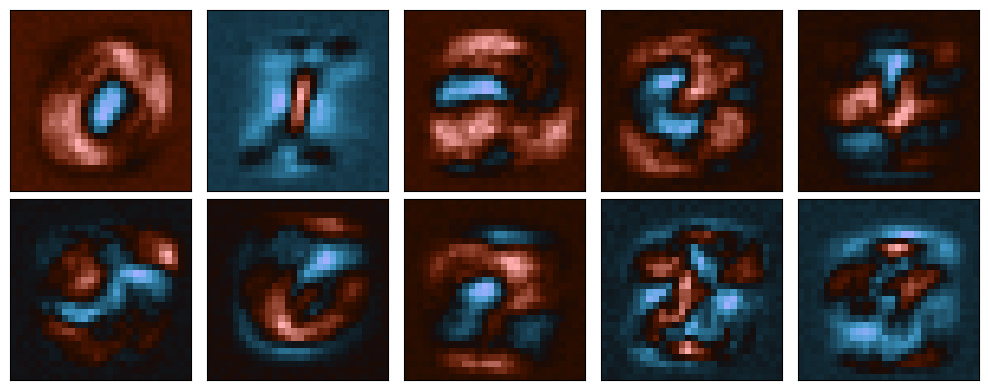

In [15]:
fig, axes = plt.subplots(2,5)
fig.set_figheight(2*2)
fig.set_figwidth(5*2)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.matshow(model.W[:,i].reshape(img_shape), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()